# 텍스트 분류 (형태소분석기이용+불용어 50개 적용) 

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
Okt = Okt()
kkma = Kkma()
hannanum = Hannanum()

In [3]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [4]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [5]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [6]:
df.shape

(8529, 17)

# 분류현황

In [7]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [8]:
category_count = df['구분'].value_counts()
category_count

기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [9]:
category_count = df['책임구'].value_counts()
category_count

구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [10]:
category_count = df['원인'].value_counts()
category_count

부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# null인 값 확인 및 제거

In [11]:
df_bak = df.copy()

In [12]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [13]:
df.shape

(8529, 17)

In [14]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [15]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [16]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [17]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

# 전처리

In [18]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['target_pred'] = df['대상 선정'].astype(str).copy()

In [25]:
#명사 추출 함수
def nounextract(text):
    text = hannanum.nouns(text)
    return text

In [26]:
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nounextract)

In [27]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    #text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [28]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [29]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

Wall time: 230 ms


In [30]:
%time df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 565 ms


In [31]:
df['clm_prtl_sbc'].head(10)

0               엔진룸    다량    연료    누유    발생      점검...
1                    리    도    앤티    취핑    필림    미장착  
2               커튼    후크    미장착    출고            커튼...
3                 차량출고시    웨즈스트립고무    주름발생    들뜸교환조치  
4      몰딩    내부    고무    미조립    상태    몰딩    조립    출고  
5           리    윈도우    판넬    트립    미장착     내용     ...
6      우측    슬라이딩    도    커튼    도리    미창작    장착    ...
7               프론트    우측    도    웨져스터립    미    부착상...
8               조수석    윗부분    누수    입고        원    ...
9      상    리어도    휀더부    불만입       점검결과    취핑테이프  ...
Name: clm_prtl_sbc, dtype: object

# 학습데이터와 테스트데이터 만들기

In [32]:
df = df.reindex() #index 재설정. reindex:새로운 색인에 맞도록 객체를 새로 생성하는 기능.

In [33]:
df.shape

(8529, 18)

In [34]:
df_train = df.sample(frac=0.9)
df_train.shape

(7676, 18)

In [35]:
df_test = df.sample(frac=0.1)
df_test.shape

(853, 18)

# 단어 벡터화

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['[C]']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 20000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=['[C]'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [37]:
#%%time 
train_feature_vector = vectorizer.fit_transform(df_train['clm_prtl_sbc'])
train_feature_vector.shape

(7676, 20000)

In [38]:
train_feature_vector.toarray().transpose()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
#%%time 
test_feature_vector = vectorizer.fit_transform(df_test['clm_prtl_sbc'])
test_feature_vector.shape

(853, 20000)

In [40]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['ab',
 'ab 전원',
 'ab 전원 어스선',
 'abs경고등및',
 'abs경고등및 경고등',
 'abs경고등및 경고등 점멸',
 'abs모듈',
 'abs모듈 교환',
 'abs모듈 문제',
 'abs모듈 문제 판단됨']

In [41]:
dist = np.sum(train_feature_vector, axis=0)
dist.shape

(1, 20000)

In [42]:
dist_pd = pd.DataFrame(dist, columns=vocab)
dist_pd

ab  ab 전원  ab 전원 어스선  abs경고등및  abs경고등및 경고등  abs경고등및 경고등 점멸  abs모듈  \
0   4      2          2        9            3               3      2   

   abs모듈 교환  abs모듈 문제  abs모듈 문제 판단됨 ...  힌지 우측  힌지 우측 커버  힌지 윤활제  힌지 윤활제 도포후  \
0         3         2             4 ...      2         2       4           2   

   힌지 체결볼트  힌지 체결볼트 이격후  힘가하  힘가하 소리않남  힘가하 소리않남 오버헤드  힘지  
0        2           27    2         2              2   2  

[1 rows x 20000 columns]

In [43]:
dist_pd_t = dist_pd.T
dist_pd_t

0
ab                                               4
ab 전원                                            2
ab 전원 어스선                                        2
abs경고등및                                          9
abs경고등및 경고등                                      3
abs경고등및 경고등 점멸                                   3
abs모듈                                            2
abs모듈 교환                                         3
abs모듈 문제                                         2
abs모듈 문제 판단됨                                     4
acc입력전원                                          4
acc입력전원 단선                                       3
acc입력전원 단선 데이터                                   7
acv밸브                                            5
acv밸브 내부                                         3
acv밸브 내부 불량                                      3
ad                                               3
ad 조수석                                          13
ad 조수석 핸들안                                       5
af                                               2
af 센서                                            2
af 센서 회로                                         2
af 센서회                                           3
af 센서회 성능이상                                     34
ahs센서이상                                          2
ahs센서이상 발생함                                      2
ahs센서이상 발생함 액티브후드센서배선및커                          5
a필라                                              2
a필라 상단부                                          2
a필라 상단부 자리                                       2
...                                             ..
히터 컨트롤 작동안                                      68
히터 회로                                            2
히터 회로 성능                                         2
히터제                                              2
히터제 이상                                           2
히터제 이상 후단nox센서                                   2
히터컨트롤                                            3
히터컨트롤 교환                                         4
히터컨트롤 교환 출고                                     19
히터컨트롤 온도                                         2
히터컨트롤 온도 조절                                      4
히터컨트롤 작동                                         2
히터컨트롤 작동 불량                                      3
히터컨트롤버튼불량발생히터컨트롤블로워모터바람세기버튼이리턴불량및작동불량발생되어교환조치함   2
히트프로텍터판넬                                         2
히트프로텍터판넬 점검                                      3
히트프로텍터판넬 점검 트렁크내                                 2
힌지                                               2
힌지 부분                                            4
힌지 부분 조립불량                                       9
힌지 우측                                            2
힌지 우측 커버                                         2
힌지 윤활제                                           4
힌지 윤활제 도포후                                       2
힌지 체결볼트                                          2
힌지 체결볼트 이격후                                     27
힘가하                                              2
힘가하 소리않남                                         2
힘가하 소리않남 오버헤드                                    2
힘지                                               2

[20000 rows x 1 columns]

In [44]:
a = dist_pd_t.sort_values(by=0, ascending = False)
a.head(50)

0
뚜두둑 뚜둑              3133
제동시 운전석 이음          2472
고무 확인됨조치            2464
슬라이딩 찌직             2267
미작동 내부 불량           1599
확인 에어컨 컴프레          1596
진동발생조치 dpf재생 dpf내부  1331
주행시 브레이크            1271
최종 시운전 강제           1135
작동시 모터케이블           1070
크랙으로커버 콘솔 상부         946
좌측 mm                943
점등 스캔시 산소센서          921
간혈적 공기압력 센서          919
슬라이딩도 닫힘불량           911
점검시 조수석시트            863
고정 불량                779
전시차량 드럼              752
하이드로백 파이프 방진재        711
조치 트렁크               706
워셔노즐                 705
시운점 점검조치 롤로드         694
증상 확인조치              682
작동불량 우측 헤드램프         680
점검 테스트및 시운전          626
외부 이물질               621
수분유입                 582
장착및                  576
우측도어트림탈착 글라스런        572
강제 재생안               569
가죽 재단                552
차체진동 시동꺼짐 차체진동       544
교환 점검                543
조정후 운전석              517
체결불량 작동불량발생조치내용      445
발생 수정트렁크             444
점등 km 이상             409
간헐적 소음발생 리어도         402
이탈 첨부조치내용 교환후        370
탑씰링안쪽 접착부위떨어짐        369
올림시 창문 안올라옴          348
리어쇼크                 345
탈거후 커넥터 전원           326
현재 운전석               320
파워 슬라이딩 콘트롤          313
이슴 발생 관련부품           312
진단시 고장코드             308
윈도우 글라스런 작동시         305
경고등 센서 히터제           300
운전석 사이드 이탈           294

In [45]:
a.plot()

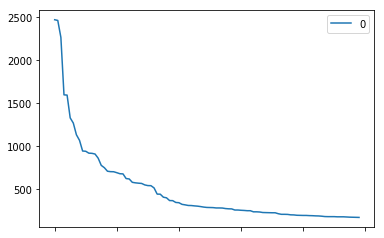

In [46]:
b = a.iloc[1:100, :]
b.plot()

# tf-idf 가중치 적용

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [48]:
#%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(7676, 20000)

In [49]:
#%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(853, 20000)

# 머신러닝 : 학습

In [50]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [51]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
y_label = df_train['target_pred']
# y_label3 = df_train['charge_pred']
%time forest = forest.fit(train_feature_tfidf, y_label)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 2.28 s


# 모델평가

In [52]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 34.7 s


array([0.75065104, 0.74332248, 0.73941368, 0.75504886, 0.76872964])

In [53]:
round(np.mean(score)*100,2)

75.14

# 예측

In [54]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['O', 'O', 'X'], dtype=object)

In [55]:
y_pred.shape

(853,)

In [56]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head(10)

category_pred
0             O
1             O
2             X
3             X
4             X
5             O
6             X
7             O
8             X
9             O

In [57]:
df_test['category_pred'] = y_pred

# 결과검증

In [58]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['대상 선정'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd  \
3311               W  2017     20171212         ZZ5         I12   
2689               W  2015     20150901         ZZ4         I11   
4677               W  2017     20170103         ZZ7         I3B   
2495               W  2015     20151007         ZZ5         I11   
4065               W  2018     20180726         ZZ3         I3A   

                ceq_psit_nm trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd  \
3311  작동불량_작동이 원활하지 않음(무거움)         KV11          YP     A9          TT   
2689              작동불량_작동안됨         KV11          YP     A9          AC   
4677      경고등 점등_경고등 점등-ABS         KV11          YP     A9          CC   
2495              작동불량_작동안됨         KV11          YP     A9          AC   
4065          경고등 점등_경고등 점등         KV11          YP     A9          EE   

     repn_part_cd                                       clm_prtl_sbc 대상 선정  \
3311        98350    신차    출고후    전면    와이퍼    닦힘    불량으로외주    유리...     X   
2689        95480       시동    불량    계기판    깜박깜박    점등       사업장  ...     X   
4677        52750     리어퓔허브    커넥터이탈    경고등    점등입고    커넥터    재조립합       O   
2495        95100             V    인버터    작동불량     인버터AC    모듈내부회...     O   
4065        39265    위       체크등    점등    입고됨DTC     P         센서...     O   

           구분   책임구    원인                 검토결과 target_pred category_pred  \
3311        N     N     N                 X---           X             O   
2689        N     N     N                 X---           X             O   
4677  기능(커넥터)  생산공장  결선불량  O-기능(커넥터)-생산공장-결선불량           O             X   
2495  기능(커넥터)    구매    부품      O-기능(커넥터)-구매-부품           O             X   
4065  기능(커넥터)    구매    부품      O-기능(커넥터)-구매-부품           O             X   

      pred_diff  
3311          0  
2689          0  
4677          0  
2495          0  
4065          0

In [59]:
diff_sum = df_test['pred_diff'].sum()
diff_sum

523

In [60]:
y_pred_len = len(y_pred)
y_pred_len

853

# 정확도

In [61]:
Acy = round(diff_sum/y_pred_len*100,1)
Acy

61.3